# Loading Data

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#pip install nrclex
from nrclex import NRCLex
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import datetime
import re
import nltk
from textblob import TextBlob
nltk.download('vader_lexicon')
nltk.download('punkt')  # For tokenization
nltk.download('averaged_perceptron_tagger')# Required for NRCLex
from transformers import pipeline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Basic Exploration

In [45]:
df = pd.read_csv('../data/csv/Merged_data.csv', delimiter=',', encoding='utf-8')

df.head(3)

,body,controversiality,created_utc,subreddit
0,I'd like to think I've dealt with cancer head ...,0,1719826058,CancerFamilySupport
1,thank you for pointing out how it’s misunderst...,0,1719799836,CrohnsDisease
2,It made me realise exactly how little I had. A...,0,1719847236,breastcancer


In [46]:
# checking for missing values
df.isna().sum()

body                0
controversiality    0
created_utc         0
subreddit           0
dtype: int64

In [47]:
#for i in df.columns:
#    print(df[i].unique())

print(df['subreddit'].unique())

print(df.dtypes)

# converting the time to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')  # Convert timestamp if necessary

['CancerFamilySupport' 'CrohnsDisease' 'breastcancer' 'thyroidcancer'
 'AskDocs' 'UlcerativeColitis' 'Autoimmune' 'BladderCancer'
 'doihavebreastcancer' 'Lymphedema' 'WomensHealth' 'ProstateCancer' 'cll'
 'Microbiome' 'predental' 'endometrialcancer' 'cancer' 'Hashimotos'
 'coloncancer' 'PreCervicalCancer' 'lymphoma' 'CancerCaregivers'
 'braincancer' 'publichealth' 'nursing' 'testicularcancer' 'lynchsyndrome'
 'HealthInsurance' 'Fuckcancer' 'BRCA' 'Cancersurvivors' 'Health'
 'leukemia' 'pancreaticcancer' 'skincancer' 'stomachcancer']
body                object
controversiality     int64
created_utc          int64
subreddit           object
dtype: object


In [48]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['body'] = df['body'].apply(preprocess_text)

df.head(2)

,body,controversiality,created_utc,subreddit
0,id like to think ive dealt with cancer head on...,0,2024-07-01 09:27:38,CancerFamilySupport
1,thank you for pointing out how its misundersto...,0,2024-07-01 02:10:36,CrohnsDisease


# Questions: 

In this exploratory data analysis, the primary goal was to gain a comprehensive understanding of the dataset that would eventually assist us to go into further advanced modeling and to answer our questions, which includes columns such as 'body', 'controversiality', 'created_utc', and 'subreddit'. 

The analysis in this section is focused on several key aspects to uncover insights within healthcare-related subreddits. Given the diversity of subreddits, we aimed to examine how emotions vary across different communities, as each subreddit likely captures unique sentiments and experiences related to health. 

The 'body' column, containing user comments, was analyzed for sentiment and emotion using tools like VADER and NRCLex to classify emotions such as sadness, anger, trust, and joy across different subreddit groups. Additionally, metrics related to 'controversiality' were explored to understand engagement and potential conflicts within discussions. The 'created_utc' column was leveraged to study temporal trends, analyzing how sentiment and emotion change over time or vary by day of the week. By examining these aspects, we were able to answer targeted questions about user experiences, sentiment distributions, engagement patterns, and common themes discussed within each community, ultimately providing a holistic view of the dataset’s emotional landscape. Overall, we use all the existing data to further truly mine into newer classification techniniques. 

## What is the sentiment distribution across these diverse healthcare subreddits?

**Purpose**: To understand how different healthcare communities perceive their situations, we analyzed the sentiment distribution across various healthcare-related subreddits by categorizing each comment as positive, negative, or neutral based on its sentiment score. Positive scores indicate optimistic or supportive comments, negative scores reflect frustration or concern, and neutral scores suggest factual or balanced tones. This analysis provides a snapshot of the emotional climate across healthcare subreddits, helping us gauge the general sentiment expressed by members of each community.

**Outcome**: It is seen that there is right skewed distribution for 'negative' and positive has a left-skewed distribution with an expection for 'WomensHealth' subreddit. The counts on an overall scale were slightly more for negative than the positive. However, as this doesn't specifically answer our questions in great depth, we explore further. 

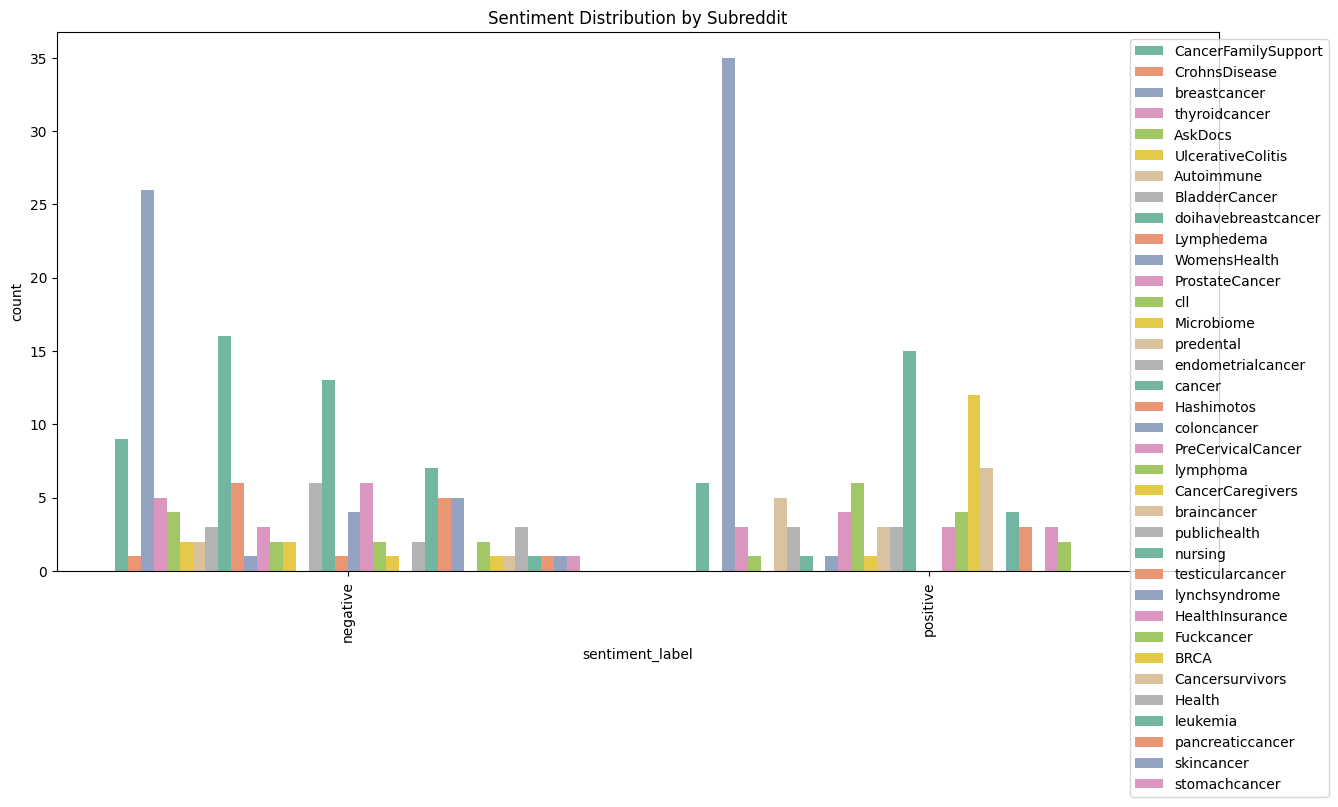

In [49]:
sid = SentimentIntensityAnalyzer()

# sentiment score and label
df['sentiment_score'] = df['body'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
custom_palette = sns.color_palette("Set2", n_colors=len(df['subreddit'].unique()))
plt.figure(figsize=(15, 7))
sns.countplot(data=df, x='sentiment_label', hue='subreddit', palette=custom_palette)
plt.title('Sentiment Distribution by Subreddit')
plt.xticks(rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

## Which emotions are most common in specific healthcare communities?

The goal of this analysis is to identify the most common emotions, such as sadness, anger, and trust, within different healthcare communities on Reddit. By examining the emotional tone of discussions in each subreddit, we can gain insights into the unique challenges and concerns faced by members of these communities. Understanding predominant emotions in specific subreddits helps reveal the emotional landscape of each group, highlighting areas of support, frustration, or other significant feelings that characterize their experiences.

**Note**: Used three approaches here 
1. TextBlob
2. Vader 
3. Transformers

**Outcome**: As we have usd three approaches to judge polarity, sentiment, and emotion, it'll be broken down accordingly

- On basis of Polarity: The analysis reveals varying predominant emotions across healthcare subreddits, with each community displaying unique emotional tones. Subreddits like braincancer and skincancer show notably high positive sentiment, possibly reflecting resilience or hope within these groups, while Fuckcancer and Hashimotos indicate stronger expressions of frustration or anger. Communities like CancerCaregivers and HealthInsurance have a more balanced emotional tone, with a mix of support and concerns.
- The sentiment analysis across healthcare subreddits shows a wide range of emotional tones. Subreddits like braincancer, predental, and HealthInsurance exhibit higher positive sentiment, possibly reflecting optimism or supportive environments. In contrast, subreddits such as UlcerativeColitis, Lymphedema, and leukemia lean more negative, indicating challenging or difficult discussions. Many subreddits, including breastcancer and cancer, have a high proportion of neutral sentiment, suggesting factual or balanced discussions. 
- The analysis of emotions across healthcare subreddits reveals a diverse emotional landscape, with certain emotions being more prominent in specific communities. For example, sadness is particularly high in subreddits such as Cancersurvivors, BRCA, and predental, likely reflecting the emotional challenges related to these conditions. Fear is notably prevalent in subreddits like skincancer, thyroidcancer, and publichealth, indicating concerns over diagnosis, treatment, and potential health risks. On the other hand, joy is relatively high in WomensHealth and braincancer, suggesting instances of shared positive experiences or supportive interactions. Anger is particularly pronounced in subreddits such as Fuckcancer and Microbiome, possibly reflecting frustration with healthcare systems, treatments, or conditions. 

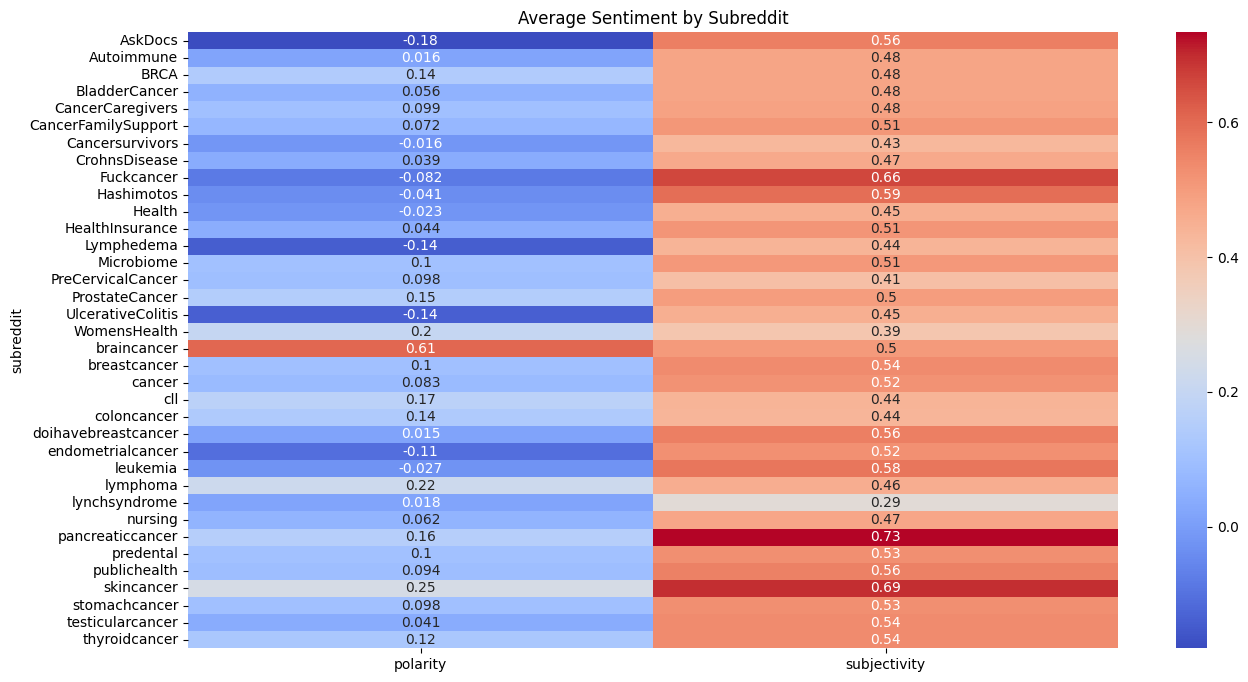

In [50]:
# using textblob for sentiment analysis as a proxy for emotion

def get_sentiment(text):
    blob = TextBlob(text)
    return {
        'polarity': blob.sentiment.polarity,       # -1 (negative) to 1 (positive)
        'subjectivity': blob.sentiment.subjectivity # 0 (objective) to 1 (subjective)
    }

sentiment_df = pd.DataFrame(df['body'].apply(get_sentiment).tolist())
sentiment_df['subreddit'] = df['subreddit']
sentiment_avg = sentiment_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(sentiment_avg, annot=True, cmap='coolwarm')
plt.title('Average Sentiment by Subreddit')
plt.show()


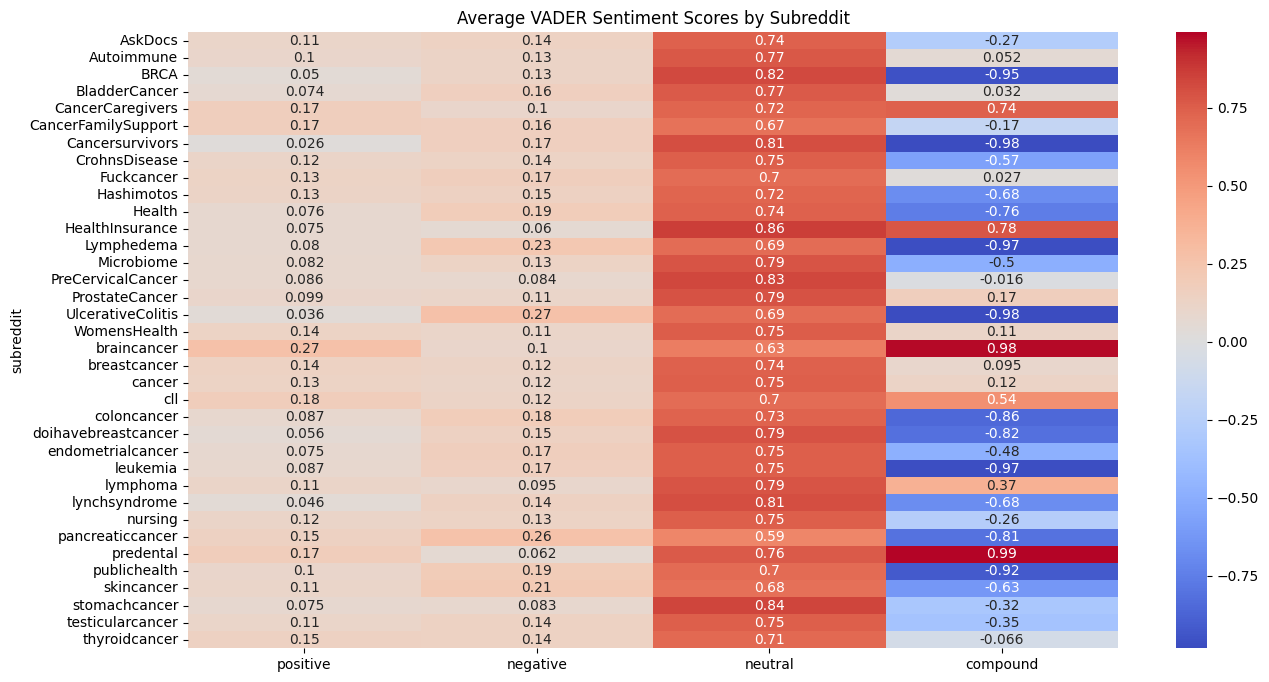

In [51]:
# using vader for emotional scoring

# VADER
sid = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    scores = sid.polarity_scores(text)
    return {
        'positive': scores['pos'],
        'negative': scores['neg'],
        'neutral': scores['neu'],
        'compound': scores['compound']
    }

vader_df = pd.DataFrame(df['body'].apply(get_vader_scores).tolist())
vader_df['subreddit'] = df['subreddit']
vader_avg = vader_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(vader_avg, annot=True, cmap='coolwarm')
plt.title('Average VADER Sentiment Scores by Subreddit')
plt.show()


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/sheebamoghal/Desktop/courses/DSAN 6000/fall-2024-project-team-35/cancer/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


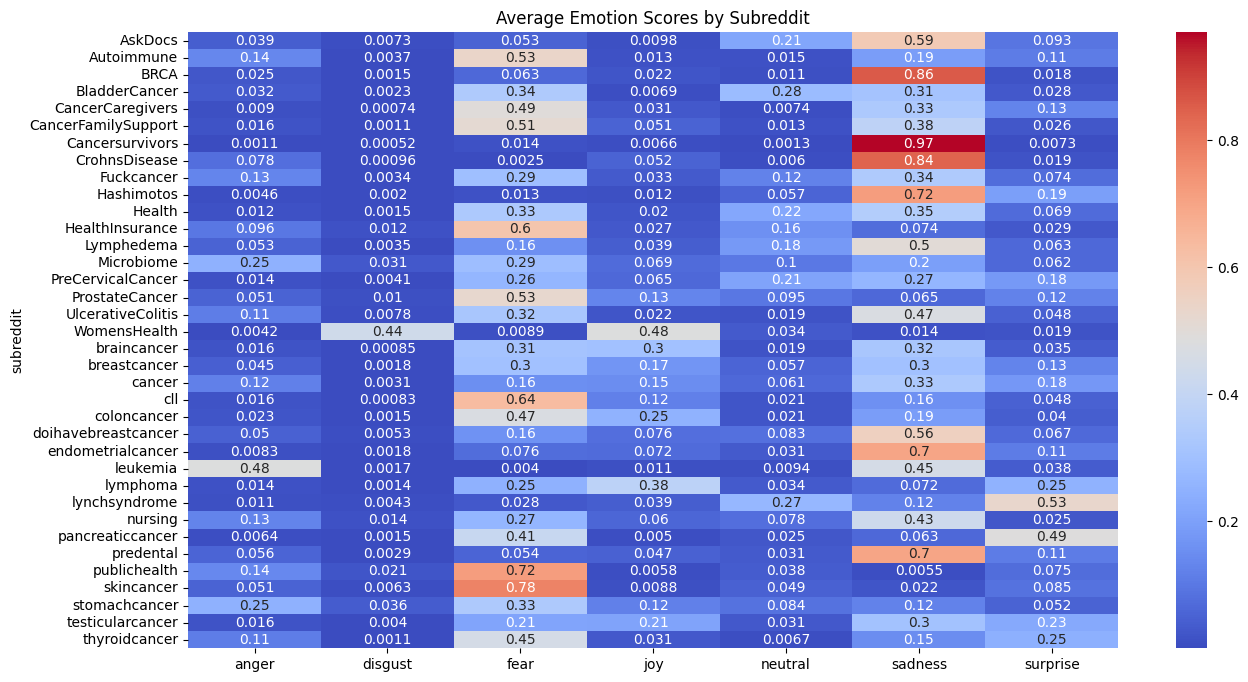

In [52]:
# using pretained transformeers model

MAX_LENGTH = 512

def truncate_text(text, max_length=MAX_LENGTH):
    tokens = text.split()  # Tokenize by whitespace
    if len(tokens) > max_length:
        text = ' '.join(tokens[:max_length])
    return text

#df['truncated_body'] = df['body'].apply(lambda x: truncate_text(x))

# loading a pretrained emotion classification model
emotion_classifier = pipeline(
    "text-classification", 
    model="j-hartmann/emotion-english-distilroberta-base", 
    return_all_scores=True, 
    truncation=True
)
def get_emotions_transformers(text):
    emotion_scores = emotion_classifier(text)[0]  # emootional scores
    # converting these list of scores to a dictionary
    return {item['label']: item['score'] for item in emotion_scores}

emotion_df = pd.DataFrame(df['body'].apply(get_emotions_transformers).tolist())
emotion_df['subreddit'] = df['subreddit']
emotion_avg = emotion_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(emotion_avg, annot=True, cmap='coolwarm')
plt.title('Average Emotion Scores by Subreddit')
plt.show()


## What are the primary topics or themes discussed in each subreddit?

**Purpose**: The goal of analyzing primary topics or themes across healthcare subreddits is to identify common areas of discussion within each community. These themes could include treatment challenges, symptom management, and the need for emotional support, among others. By understanding the primary concerns in each subreddit, we can gain insights into what matters most to different healthcare communities. Additionally, exploring correlations between these topics and sentiment may reveal how specific discussions align with positive, negative, or neutral emotions, providing a deeper understanding of each community's unique experiences and perspectives.

**Outcome**: The topic analysis across healthcare subreddits reveals a variety of key themes discussed within these communities. Topic 1 centers around understanding medical treatments, particularly radiation and prostate-related issues, suggesting a need for clarity on complex procedures. Topic 2 highlights patient-doctor relationships and the desire for reassurance regarding symptoms like lumps, indicating some mistrust or frustration with healthcare providers. Topic 3 reflects general concerns about treatment and care, as well as the challenges of navigating personal health decisions. Topic 4 focuses on experiences with pain and family dynamics, with mentions of “mom” and “dad,” suggesting that family support plays a significant role in coping with diagnoses. Lastly, Topic 5 discusses life-impacting elements of treatment, like blood work, chemotherapy, and managing side effects. 

In [53]:
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df['body'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# topic modeling using LDA 
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic 1:
['people', 'able', 'things', 'dont', 'understand', 'prostate', 'radiation', 'medicine', 'like', 'im']
Topic 2:
['need', 'feeling', 'doctors', 'dont', 'lump', 'right', 'people', 'im', 'just', 'did']
Topic 3:
['dont', 'people', 'just', 'like', 'im', 'care', 'things', 'treatment', 'know', 'need']
Topic 4:
['lot', 'pain', 'diagnosed', 'like', 'im', 'just', 'mom', 'know', 'dad', 'time']
Topic 5:
['dont', 'blood', 'life', 'didnt', 'port', 'time', 'body', 'im', 'days', 'chemo']


## Are certain subreddits more likely to express interpersonal conflict or emotional support?

**Purpose**: 
This analysis aims to identify which subreddits are more likely to feature discussions about interpersonal conflict or emotional support, highlighting the role of community dynamics in health-related experiences. By examining the frequency of keywords associated with conflict—such as negative emotions, struggles, and relational challenges—and support keywords that signify kindness, empathy, and encouragement, we can determine which communities focus more on sharing challenges versus offering support.


**Outcome**: The analysis of conflict and support mentions across healthcare subreddits reveals varying dynamics in community interactions. Subreddits like Autoimmune, CrohnsDisease, Fuckcancer, and HealthInsurance exhibit high levels of both conflict and support, indicating that members frequently discuss frustrations as well as offer mutual encouragement. In contrast, communities such as Cancersurvivors, Lymphedema, and PreCervicalCancer have high support but little conflict, suggesting a stronger focus on encouragement and empathy rather than interpersonal challenges. Other subreddits like BRCA, Hashimotos, and Microbiome display high conflict with minimal support, potentially reflecting specific challenges or frustrations unique to those conditions. 

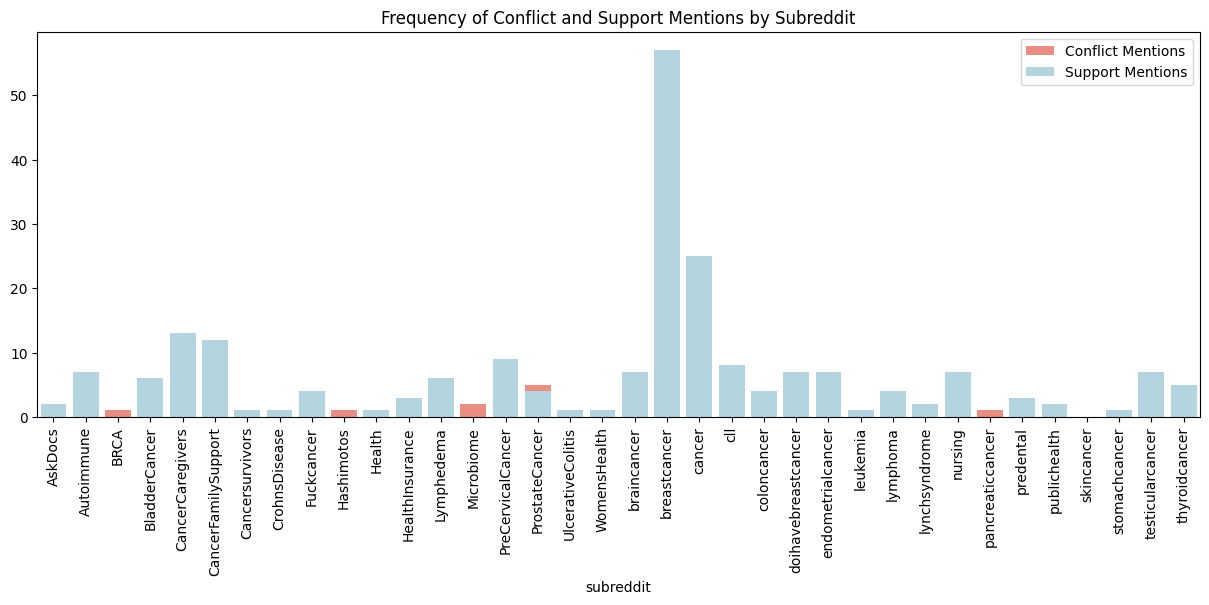

In [54]:
conflict_keywords = [
    "frustration", "disappointment", "anger", "resentment", "annoyance", "conflict", 
    "tension", "irritation", "betrayal", "arguments", "struggle", "stress", 
    "misunderstanding", "criticism", "blame", "guilt", "hostility", "resent", 
    "unhappy", "sadness", "upset", "hurt", "fighting", "argument", "tough", 
    "challenging", "difficulty", "pressure", "discouragement", "despair", 
    "fear", "helplessness", "hopelessness", "loss", "disapproval", "rejection", 
    "grief", "pain", "suffering", "alienation", "abandonment", "desperation", 
    "friction", "dispute", "distrust", "confusion", "embarrassment", "injustice", 
    "unfair", "isolation", "loneliness", "agitation", "disgust", "irritability", 
    "exclusion", "condemnation", "bitterness", "exasperation", "discontent", 
    "jealousy", "envy", "regret", "doubt", "turmoil", "burden", "anxiety", 
    "pressure", "insecurity", "worry", "distress", "disillusionment", "strife", 
    "unresolved", "torment", "persecution", "victimization", "abrasiveness", 
    "defiance", "rebellion", "protest", "contempt", "accusation", "attack", 
    "judgment", "exclusion", "neglect", "withdrawal", "abuse", "mockery", "clash"
] # added more words to balance the viz

support_keywords = [
    "support", "help", "care", "encourage", "comfort", "kindness", "understanding", 
    "compassion", "empathy", "assistance", "guidance", "backing", "aid", "uplifting", 
    "positive", "friendship", "community", "reassurance", "sympathy", "solidarity", 
    "together", "listening", "patience", "trust", "love", "appreciation", "encouragement", 
    "advice", "warmth", "respect", "hope", "motivating", "strength", "connection"
]

df['conflict_mention'] = df['body'].apply(lambda x: any(keyword in x for keyword in conflict_keywords))
df['support_mention'] = df['body'].apply(lambda x: any(keyword in x for keyword in support_keywords))

conflict_counts = df.groupby('subreddit')['conflict_mention'].sum()
support_counts = df.groupby('subreddit')['support_mention'].sum()

plt.figure(figsize=(15, 5))
sns.barplot(x=conflict_counts.index, y=conflict_counts.values, color='salmon', label='Conflict Mentions')
sns.barplot(x=support_counts.index, y=support_counts.values, color='lightblue', label='Support Mentions')
plt.title('Frequency of Conflict and Support Mentions by Subreddit')
plt.xticks(rotation=90)
plt.legend()
plt.show()


## How does sentiment vary over time within different healthcare communities?

**Purpose**: The goal of this analysis is to examine how sentiment fluctuates over time within different healthcare communities. By identifying temporal trends in sentiment, we can uncover patterns that may reflect the impact of external events or stages in personal health journeys. For instance, certain healthcare subreddits might experience shifts in sentiment during awareness months, treatment advancements, or policy changes, while others may show personal emotional cycles as members navigate ongoing health challenges. 

**Outcome**: As there is no pull of data across time, we are leaving this to work on it later

In [55]:
df['date'] = df['created_utc'].dt.date
#print(df['date'].unique()) # so didnt work so can we expand the data? 

## What is the average sentiment score?

**Purpose**: The purpose of calculating the average sentiment score is to understand the general emotional tone across different subreddits. By examining the average sentiment for each subreddit, we can gain insights into whether discussions within these communities tend to be positive, negative, or neutral overall. This analysis helps identify which healthcare communities are more optimistic or challenged in their outlook, offering a broader view of the emotional landscape within each subreddit.

**Outcome**: The sentiment analysis for healthcare subreddits on July 1, 2024, reveals a range of emotional tones across communities. Subreddits like CancerCaregivers (0.737608) and predental (0.9921) have positive sentiment scores, suggesting a supportive or encouraging atmosphere among members. On the other hand, communities like BRCA (-0.9525), Cancersurvivors (-0.9826), and CrohnsDisease (-0.569) show more negative sentiment, potentially indicating challenges, frustrations, or concerns commonly shared by these users. Several subreddits, such as BladderCancer (0.031667) and AskDocs (-0.26722), exhibit scores closer to neutral, implying a balanced mix of positive and negative experiences. This on an overall scale of sentiment scores highlights the diversity of emotional climates within these healthcare communities, reflecting the unique support needs and challenges faced by each group.

<Figure size 1500x800 with 0 Axes>

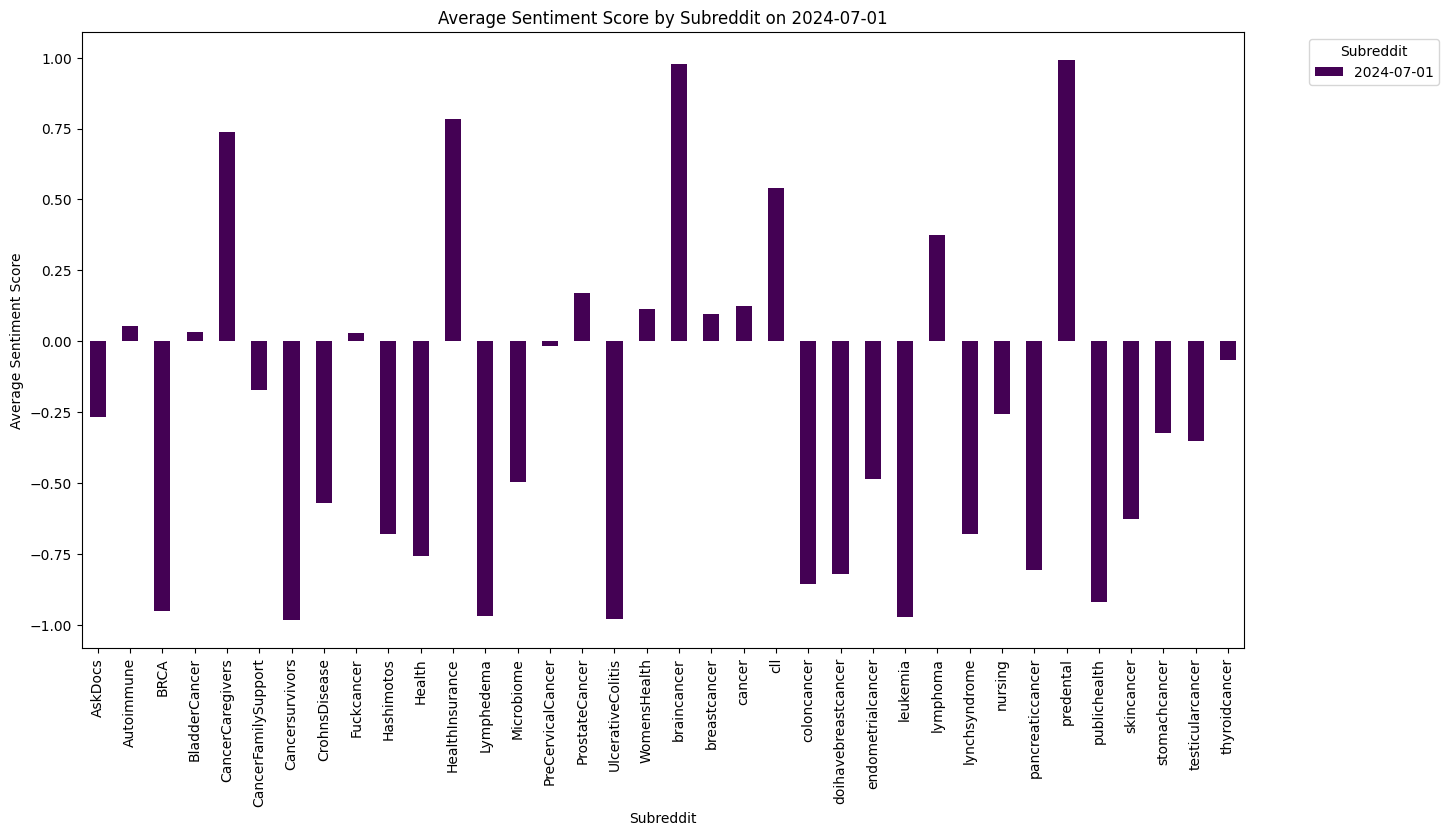

In [56]:
daily_sentiment = df.groupby(['date', 'subreddit'])['sentiment_score'].mean().unstack()
plt.figure(figsize=(15, 8))
daily_sentiment.T.plot(kind='bar', figsize=(15, 8), colormap="viridis")
plt.title('Average Sentiment Score by Subreddit on {}'.format(daily_sentiment.index[0]))
plt.xlabel('Subreddit')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.legend(title="Subreddit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## How is the sentiment score distribution?

**Purpose**: To analyze the distribution of sentiment scores across healthcare subreddits, providing insight into the range of emotions expressed by community members. This analysis helps identify whether discussions tend to lean more positive, negative, or neutral overall and reveals the diversity of emotional experiences within each subreddit. By examining the sentiment score distribution, we gain a clearer picture of the general mood and the emotional dynamics present in these healthcare communities.

**Outcome**: The sentiment score distribution across healthcare subreddits reveals significant variability in the emotional tone of discussions. Subreddits like CancerCaregivers and ProstateCancer have a wide range of sentiment scores, extending from highly negative to highly positive, indicating mixed experiences and emotions. Some communities, such as braincancer and predental, show consistently positive scores, suggesting a more supportive or optimistic atmosphere. Conversely, subreddits like BRCA, Cancersurvivors, and UlcerativeColitis have consistently low sentiment scores, reflecting a generally negative emotional tone. Other subreddits, such as Autoimmune and WomensHealth, display a balanced distribution, with both positive and negative sentiment expressed. 

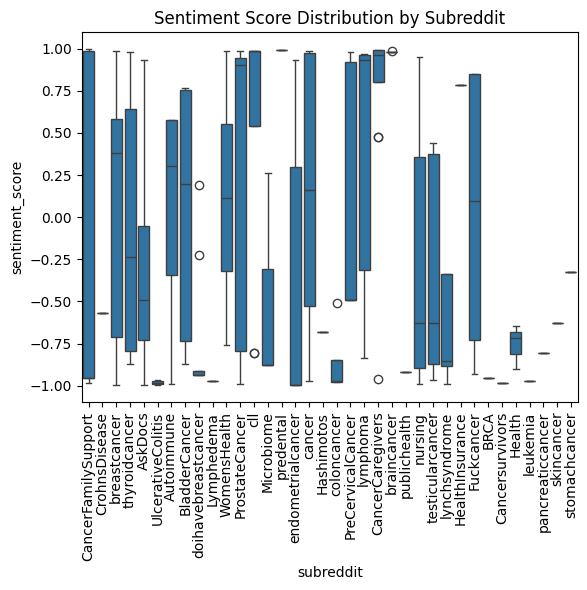

In [57]:
sns.boxplot(data=df, x='subreddit', y='sentiment_score')
plt.xticks(rotation=90)
plt.title('Sentiment Score Distribution by Subreddit')
plt.show()



## Is there any association between the comment length and the sentiment?

**Purpose**: To explore the relationship between comment length and sentiment, as longer comments may reflect more detailed personal experiences or intense emotions, while shorter comments might be more factual or express brief support or frustration. By examining this association, we can gain insights into how the depth of engagement in comments correlates with emotional expression across healthcare communities. This analysis may reveal whether individuals expressing strong sentiments tend to elaborate more on their experiences compared to those with neutral or less intense sentiments.

**Outcome**: 

- a. The average comment length varies widely across healthcare subreddits, reflecting different levels of engagement. Subreddits like HealthInsurance, UlcerativeColitis, and predental have longer comments, suggesting more detailed discussions. In contrast, communities like skincancer, pancreaticcancer, and Health have shorter comments, likely indicating brief or factual exchanges. These variations highlight differences in the depth of interaction within each community.

- b. In terms of the association between commenth length and sentiment score, though it is a visual scatterplot, there is not much association betweent the both. The length of 100 for instance, has sentiment scores between -1 and +1, and also for longer comment lengths. But as the length of the comment increased, the sentiment scores are at it's extreme or rather more pronounced.

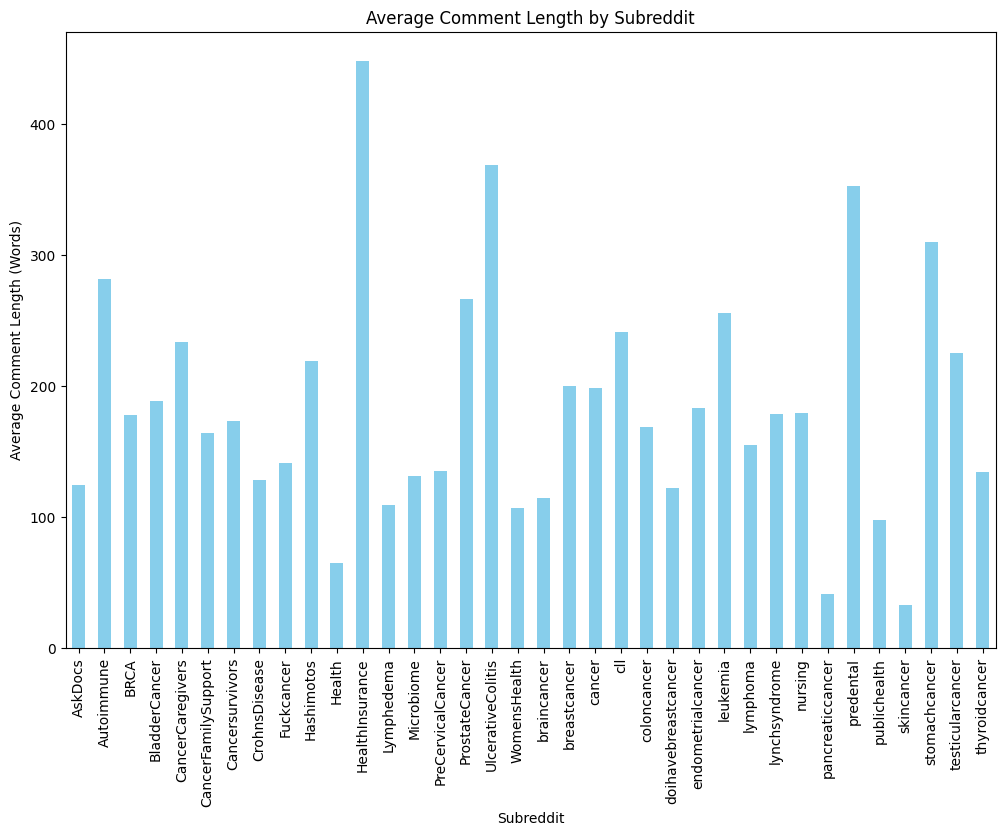

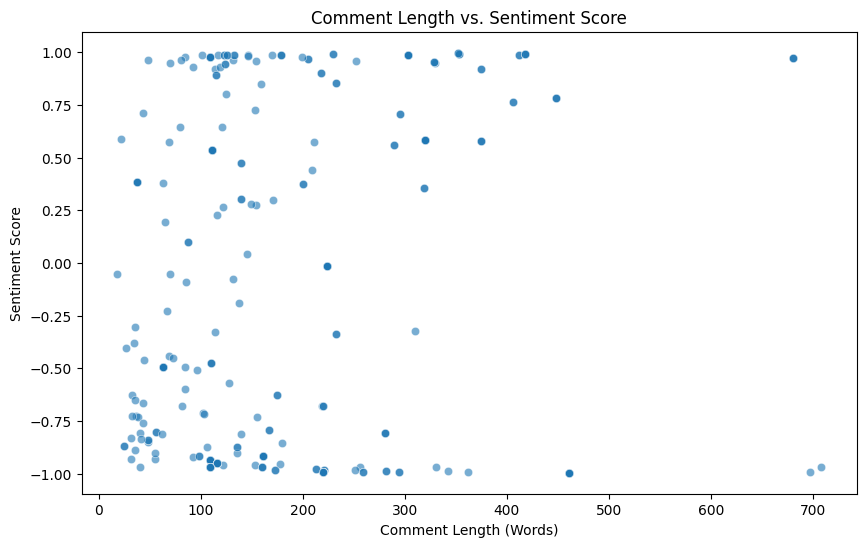

In [58]:
# lengh of comments
df['comment_length'] = df['body'].apply(lambda x: len(x.split()))

# avg comment length by subreddit
avg_length_per_subreddit = df.groupby('subreddit')['comment_length'].mean()


plt.figure(figsize=(12, 8))
avg_length_per_subreddit.plot(kind='bar', color='skyblue')
plt.title('Average Comment Length by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Comment Length (Words)')
plt.xticks(rotation=90)
plt.show()

# comment length vs. sentiment score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='comment_length', y='sentiment_score', alpha=0.6)
plt.title('Comment Length vs. Sentiment Score')
plt.xlabel('Comment Length (Words)')
plt.ylabel('Sentiment Score')
plt.show()


## How does the engagement differ across different subreddits?

**Purpose**: To understand how engagement varies across different subreddits, potentially highlighting topics that strongly resonate with the community or address relevant, relatable issues. Here, we analyze engagement using metrics like 'controversiality' and 'mentions' to uncover patterns in community response.

**Outcomes**: 
- Using Controversiality: The data reveals that most subreddits exhibit low to zero levels of "controversiality," indicating minimal engagement or conflict in community interactions for most topics. However, a few subreddits, such as lymphoma and nursing, show slightly higher values, suggesting that discussions in these communities may spark more diverse opinions or higher engagement.
- Using "Conflict" and "Support Mentions": This shows significant variation in community dynamics. Subreddits like Autoimmune, CrohnsDisease, Fuckcancer, HealthInsurance, and braincancer have high percentages for both conflict and support mentions, suggesting these communities frequently discuss both interpersonal challenges and offer mutual support. On the other hand, subreddits like Cancersurvivors and CancerCaregivers reflect a high level of support mentions but little conflict, possibly indicating these communities focus more on encouragement and less on contentious discussions. Subreddits such as thyroidcancer and testicularcancer have moderate levels of both conflict and support, showing a balanced mix of challenges and supportive exchanges. Conversely, topics like Lymphedema, WomensHealth, and skincancer show lower engagement in conflict or support discussions, which might indicate less emphasis on community interaction for these specific conditions.

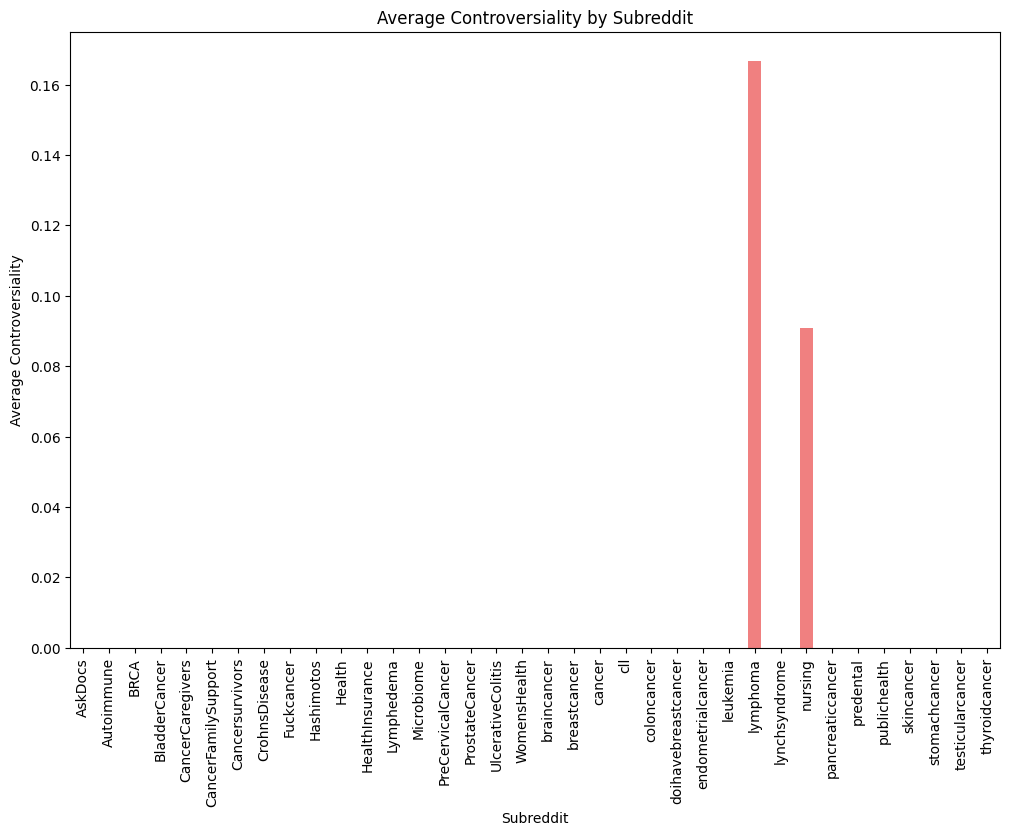

In [59]:
# avg controversiality per subreddit
avg_controversiality_per_subreddit = df.groupby('subreddit')['controversiality'].mean()
plt.figure(figsize=(12, 8))
avg_controversiality_per_subreddit.plot(kind='bar', color='lightcoral')
plt.title('Average Controversiality by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Controversiality')
plt.xticks(rotation=90)
plt.show()


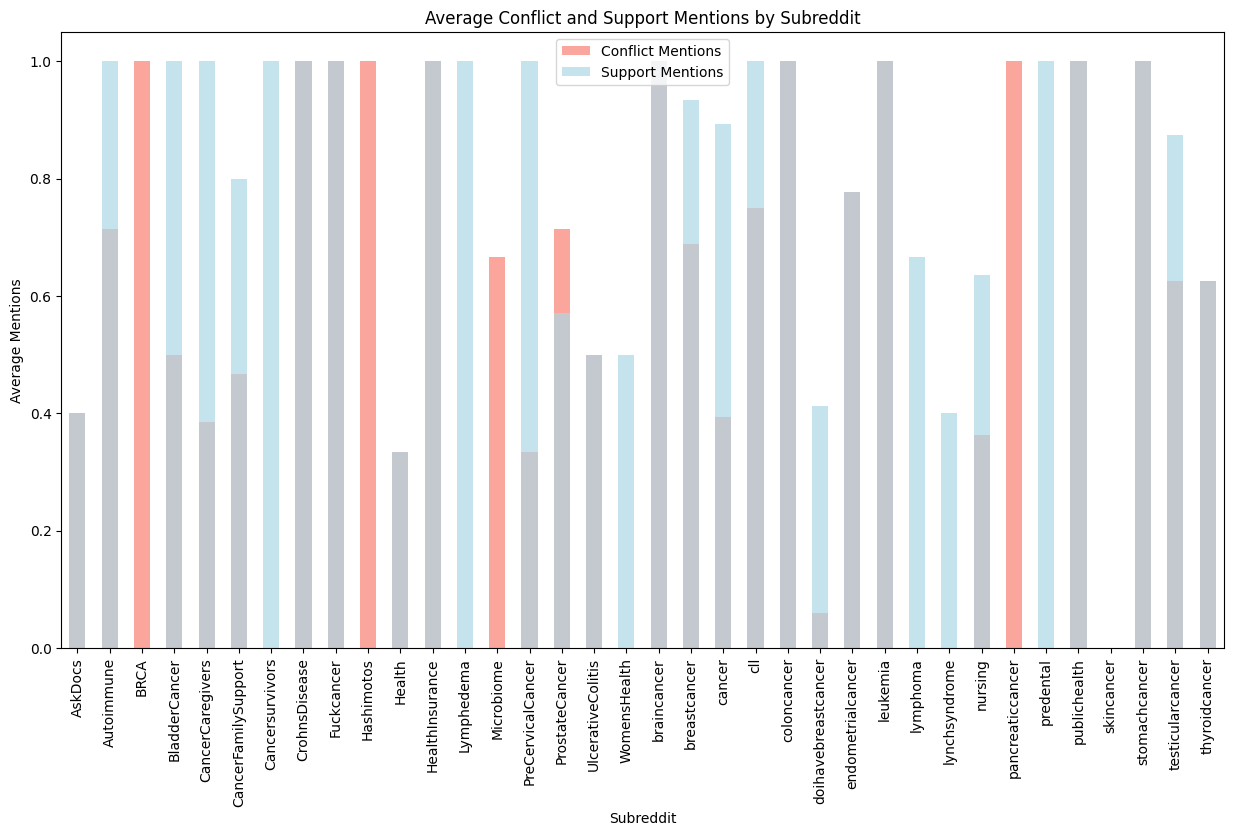

In [60]:
# avg frequency of conflict and support mentions per subreddit
conflict_counts = df.groupby('subreddit')['conflict_mention'].mean()
support_counts = df.groupby('subreddit')['support_mention'].mean()
plt.figure(figsize=(15, 8))
conflict_counts.plot(kind='bar', color='salmon', alpha=0.7, label='Conflict Mentions')
support_counts.plot(kind='bar', color='lightblue', alpha=0.7, label='Support Mentions')
plt.title('Average Conflict and Support Mentions by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Mentions')
plt.xticks(rotation=90)
plt.legend()
plt.show()


## What are the most common words or phrases for positive versus negative comments?

**Purpose**: Identifying the most common words in positive versus negative comments provides insight into the experiences and attitudes within the community. This analysis helps uncover topics, concerns, and emotions associated with each sentiment, offering a more nuanced understanding of the community's overall mood and focus.

**Outcome**: The most common words within positive and negative comments, we observe frequent use of personal pronouns like "I," "my," and "you," suggesting that these comments are often personal narratives or responses directed toward others. Words like "cancer," "treatment," and "was" appear across both sentiment categories, highlighting the centrality of health experiences in these discussions. In positive comments, expressions such as "to," "and," and "but" indicate explanatory language, often associated with sharing advice or encouragement. Conversely, negative comments include words like "not" and "so," hinting at expressions of dissatisfaction, frustration, or challenges.

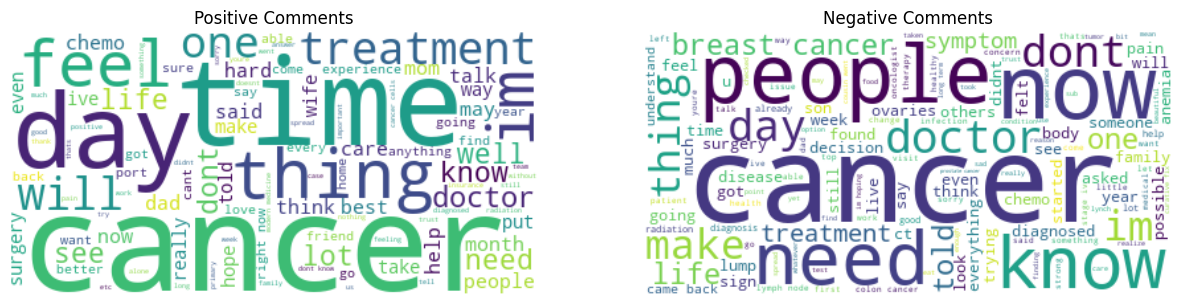

In [61]:
# positive vs negative
positive_comments = ' '.join(df[df['sentiment_score'] > 0]['body'])
negative_comments = ' '.join(df[df['sentiment_score'] < 0]['body'])


plt.figure(figsize=(15, 7))

# positive
plt.subplot(1, 2, 1)
wordcloud = WordCloud(background_color='white').generate(positive_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Comments')

# negative
plt.subplot(1, 2, 2)
wordcloud = WordCloud(background_color='white').generate(negative_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Comments')

plt.show()


## Are there specific times of day or days of the week when users discuss certain emotions more frequently?

**Purpose**: To identify patterns in the timing of emotional discussions, revealing when users are most active or in need of support. This can help understand community dynamics and determine whether certain emotions are more prevalent at specific times or days, providing insights into user engagement and support needs.

**Outcome**: As it is only for one day, we can only do it across the hour. The graph presents sentiment scores across different hours on Monday, indicating variations in sentiment throughout the day. For example, positive sentiment peaks around 8 am and 12 pm, as reflected by scores of 0.377 and 0.253 respectively, while negative sentiment is more prominent at 6 am, 9 am, and 5 pm, with values like -0.664, -0.504, and -0.953. Though it would be better to do it across time.

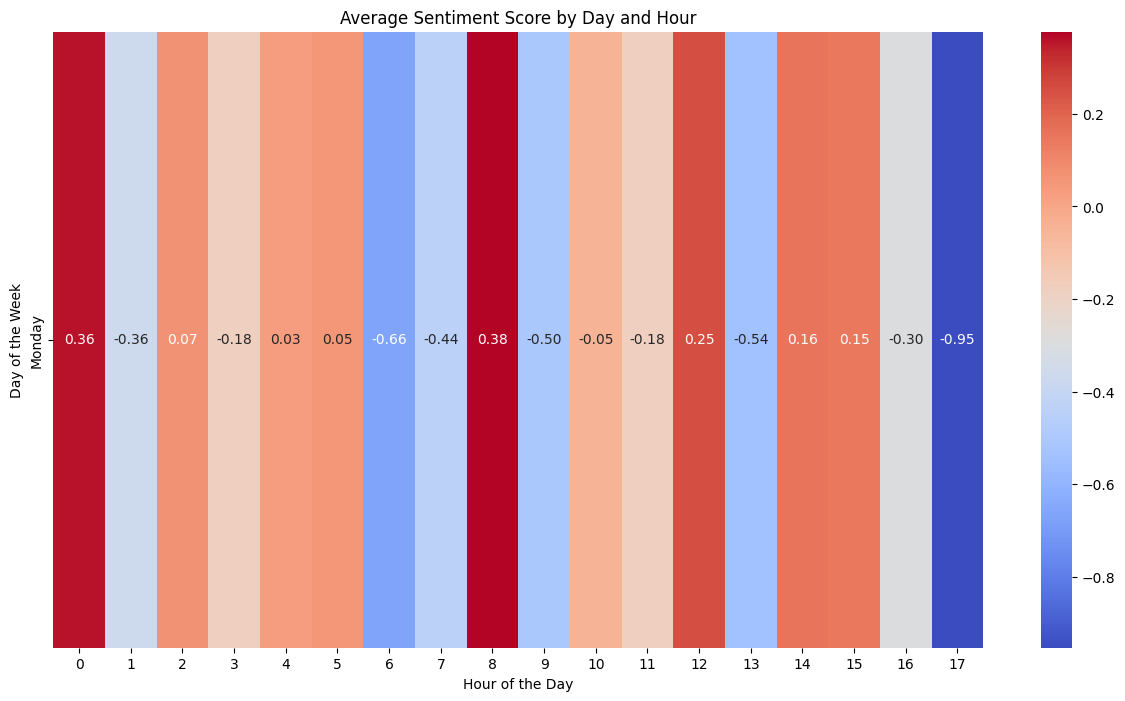

In [62]:
# day of the week and hour extraction
df['day_of_week'] = df['created_utc'].dt.day_name()
df['hour'] = df['created_utc'].dt.hour

#  verage sentiment score by day of week and hour
emotion_by_time = df.groupby(['day_of_week', 'hour'])['sentiment_score'].mean().unstack()

# heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(emotion_by_time, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Average Sentiment Score by Day and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()


## Is there a difference in sentiment or emotion between users who post frequently versus those who post infrequently?

**Purpose**: To explore whether frequent posters differ in sentiment or emotional expression compared to infrequent posters, potentially indicating deeper engagement or ongoing health concerns. Since unique user IDs aren’t available, comment length will be used as a proxy for engagement, with longer comments representing more involved or frequent contributors.

**Outcome**: The sentiment scores suggest that frequent posters have a generally neutral sentiment with a slight positive inclination (-0.011), whereas infrequent posters lean more negative with a sentiment score of -0.407. This indicates that users who post more often may express more balanced or slightly positive emotions, while those who post infrequently tend to express more negativity in their comments. This could reflect a higher level of involvement or support within the community for frequent posters, while infrequent posters may only engage during times of distress or negative experiences.

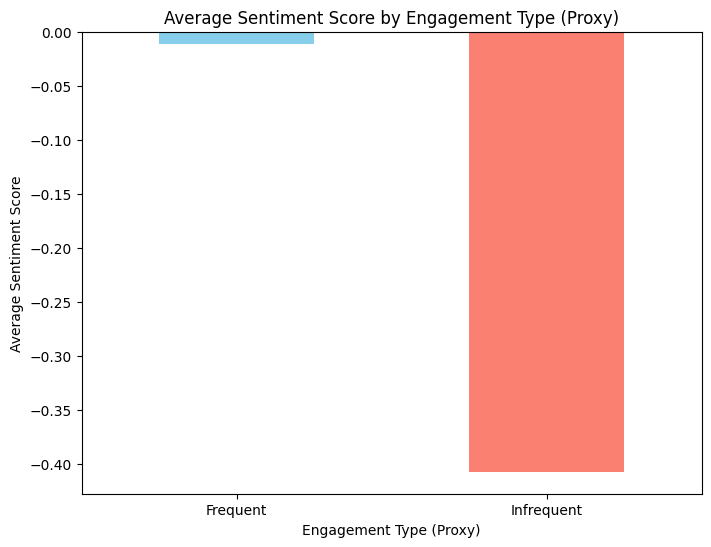

In [63]:
# comment length in terms of word count
df['comment_length'] = df['body'].apply(lambda x: len(x.split()))

# comment length threshold (e.g., more than 50 words as 'detailed' but can edit this
df['engagement_type'] = df['comment_length'].apply(lambda x: 'Frequent' if x > 50 else 'Infrequent')

# average sentiment score by engagement type
avg_sentiment_engagement = df.groupby('engagement_type')['sentiment_score'].mean()
plt.figure(figsize=(8, 6))
avg_sentiment_engagement.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Sentiment Score by Engagement Type (Proxy)')
plt.xlabel('Engagement Type (Proxy)')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()


## Do specific healthcare-related terms or topics (e.g., “treatment,” “diagnosis,” “insurance”) correlate with particular emotions?

**Purpose:** To explore whether specific healthcare-related terms or topics, like "treatment," "diagnosis," or "insurance," are associated with distinct emotions. For example, discussions around insurance may evoke frustration, while conversations about successful treatments could elicit feelings of relief. Understanding these correlations can provide insight into the emotional landscape surrounding different aspects of healthcare within the community.

**Outcome**: The sentiment scores across various healthcare subreddits show notable variation. Subreddits like CancerCaregivers and WomensHealth display high positive sentiment, potentially reflecting supportive environments or success stories within these communities. Conversely, subreddits such as UlcerativeColitis and Cancersurvivors show significantly negative sentiment scores, possibly indicating the challenges or frustrations often shared in these groups. Topics like HealthInsurance and thyroidcancer have more moderate positive sentiments, while pancreaticcancer and publichealth lean negative, suggesting complex or distressing issues discussed in these areas. This variety in sentiment scores highlights the diverse emotional landscapes within different healthcare communities.

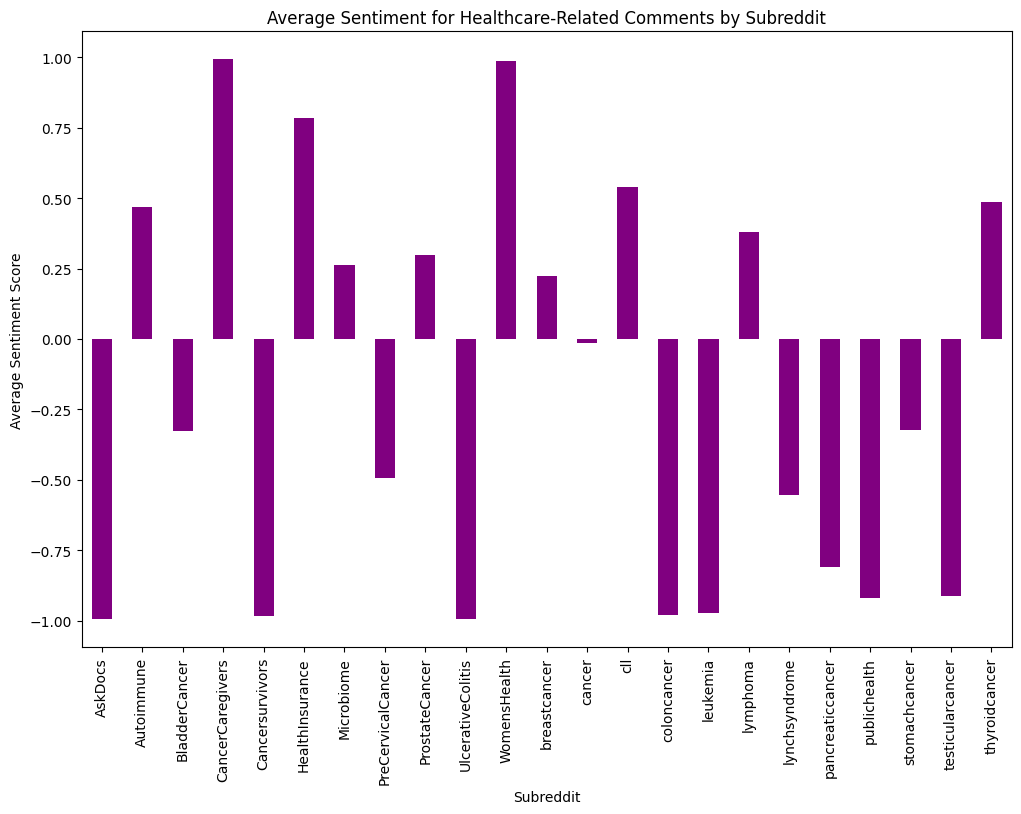

In [64]:
# filtweing comments with healthcare terms 
healthcare_terms = ["treatment", "diagnosis", "insurance"] # can edit this
df['mentions_healthcare'] = df['body'].apply(lambda x: any(term in x.lower() for term in healthcare_terms))

# average sentiment score for comments mentioning healthcare terms
avg_emotion_healthcare = df[df['mentions_healthcare']].groupby('subreddit')['sentiment_score'].mean()
plt.figure(figsize=(12, 8))
avg_emotion_healthcare.plot(kind='bar', color='purple')
plt.title('Average Sentiment for Healthcare-Related Comments by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.show()


## What are the most common expressions of gratitude, frustration, or hope?

**Purpose:**  Identifying the most common expressions of gratitude, frustration, and hope offers valuable insight into the language used for support, shared challenges, and encouragement within healthcare communities. This analysis helps uncover how individuals convey their emotions, revealing the words and phrases that resonate most when expressing appreciation, challenges, or optimism. 

**Note**: The words are editable

**Outcome**: The data reveals that "hope" is the most frequently expressed emotion among the three categories, with 62 mentions. This suggests that individuals within these healthcare communities often express optimism or a desire for positive outcomes. Expressions of gratitude, with 22 mentions, indicate an appreciation for support or shared experiences, reflecting a sense of community and thankfulness. In contrast, "frustration" is mentioned less frequently, with 6 mentions, signaling that while there are challenges, they may be less dominant in the discourse compared to hopeful or thankful sentiments. This analysis, using keywords like "thank you," "frustrated," and "hope," helps highlight the tone of discussions within these communities.

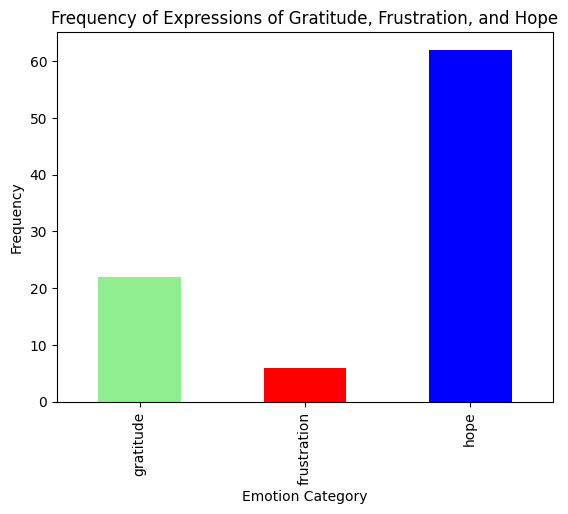

In [65]:
# keywords for each emotion category

# can edit these words to anything else
gratitude_keywords = ["thank you", "thanks", "appreciate"]
frustration_keywords = ["frustrated", "annoyed", "disappointed"]
hope_keywords = ["hope", "optimistic", "wish"]

df['gratitude'] = df['body'].apply(lambda x: any(word in x.lower() for word in gratitude_keywords))
df['frustration'] = df['body'].apply(lambda x: any(word in x.lower() for word in frustration_keywords))
df['hope'] = df['body'].apply(lambda x: any(word in x.lower() for word in hope_keywords))
emotion_counts = df[['gratitude', 'frustration', 'hope']].sum()
emotion_counts.plot(kind='bar', color=['lightgreen', 'red', 'blue'])
plt.title('Frequency of Expressions of Gratitude, Frustration, and Hope')
plt.xlabel('Emotion Category')
plt.ylabel('Frequency')
plt.show()


## Are there differences in the types of issues discussed by new users versus long-time users?

Long-time users may focus on sharing ongoing challenges or offering guidance, whereas new users are likely to seek initial support or information. UserID data would be ideal for accurately identifying new versus long-time users, as it would enable a more precise classification based on user history and posting frequency.

## What are the patterns of conversation in highly controversial versus non-controversial comments?

**Purpose**: To identify topics that spark strong reactions or disagreements within the community by examining highly controversial comments, providing insight into issues that may lead to divided opinions or heightened sensitivity.

**Outcome:** The average sentiment score for highly controversial comments is positive at approximately 0.45, while non-controversial comments tend to have a slightly negative sentiment, averaging around -0.06. This suggests that discussions in controversial comments might evoke a more intense range of emotions, potentially reflecting the engagement or importance of the issues raised.


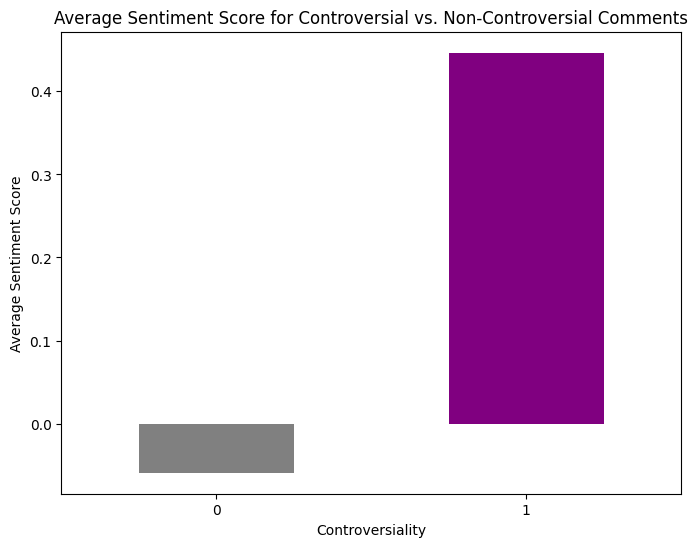

In [66]:
# avg sentiment for controversial vs. non-controversial comments
avg_sentiment_controversial = df.groupby('controversiality')['sentiment_score'].mean()
plt.figure(figsize=(8, 6))
avg_sentiment_controversial.plot(kind='bar', color=['gray', 'purple'])
plt.title('Average Sentiment Score for Controversial vs. Non-Controversial Comments')
plt.xlabel('Controversiality')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()


## How do emotional responses change when users discuss their own health experiences versus others’ experiences?

**Purpose** To understand if users show distinct emotional responses when sharing their own health experiences versus supporting others, providing insight into how personal versus supportive perspectives influence the type and intensity of emotions expressed. This can help identify patterns of empathy, vulnerability, or encouragement within the community.

**Outcome**: The sentiment analysis shows varying emotional responses based on whether users are discussing their own health experiences or others' experiences. When discussing their own health challenges alone, users express more negative sentiment (average sentiment score of -0.398). In contrast, users who mention both personal and others' experiences exhibit a slight positive sentiment (0.072). Users focusing solely on others’ experiences show a less negative sentiment (-0.095) compared to personal discussions. This suggests that users may exhibit more vulnerability or frustration when discussing personal challenges, while discussions about others' experiences might invoke more neutral or positive support-oriented responses.

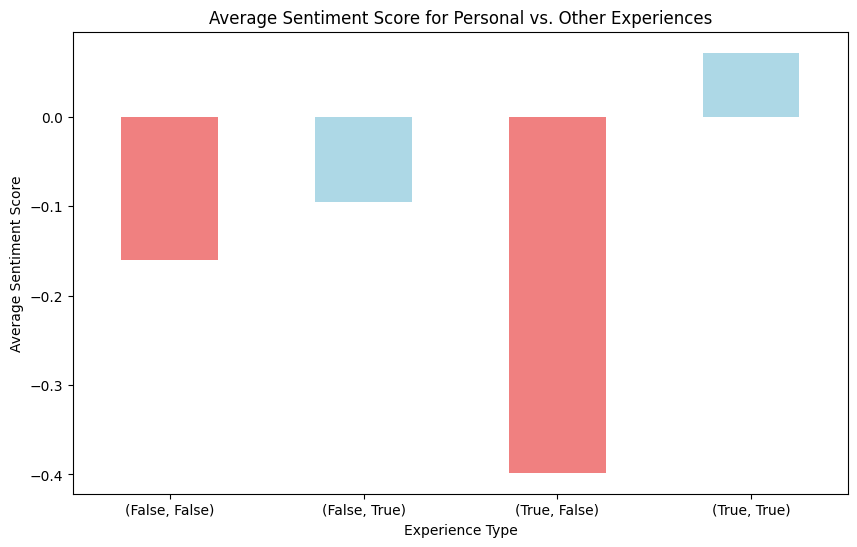

In [67]:
# using "my" and "your" personal and other-focused comments
df['personal_experience'] = df['body'].apply(lambda x: "i " in x.lower() or "my " in x.lower())
df['other_experience'] = df['body'].apply(lambda x: "you " in x.lower() or "your " in x.lower())

# avg sentiment for personal vs. other experiences
avg_sentiment_experience = df.groupby(['personal_experience', 'other_experience'])['sentiment_score'].mean()
plt.figure(figsize=(10, 6))
avg_sentiment_experience.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Average Sentiment Score for Personal vs. Other Experiences')
plt.xlabel('Experience Type')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()
